In [1]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [25]:
import torch
M = torch.zeros((27*27, 27), dtype=torch.int32)
for w in words:
  chs = ['.','.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    M[ix1*27+ix2, ix3] += 1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20*20))
plt.imshow(M, cmap='Blues')
for i in range(27*27):
    for j in range(27):
            chstr = itos[i//27] + itos[i%27] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
            plt.text(j, i, M[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [42]:
P = (M+1).float()
P = P / P.sum(dim=1, keepdim=True)

In [46]:

g = torch.Generator().manual_seed(2148971)
for _ in range(10):
    idx1 = 0
    out = ['.','.']
    while True:
        idx = torch.multinomial(P[idx1], num_samples = 1, replacement=True, generator=g).item()
        if idx==0:
            break
        out.append(itos[idx])
        idx1 = (idx1%27)*27+idx
    print(''.join(out))


..dre
..jel
..alleyvideveomilielia
..dav
..de
..te
..jan
..ken
..quelliahier
..rok


In [86]:
#nll
n = 0
pll = 0
for w in words:
    word = ['.','.']+list(w)+['.']
    for ch1, ch2, ch3 in zip(word, word[1:],word[2:]):
        index_0 = stoi[ch1]*27 + stoi[ch2]
        index_1 = stoi[ch3]
        p = P[index_0, index_1]
        plog = torch.log(p)
        pll += plog
        n += 1
print(f'pll=')
print(f'nll={-pll}')
print(f'mean nll={-pll/n}')



pll=
nll=504653.0
mean nll=2.2119739055633545


In [111]:
xs = []
ys = []
for w in words:
    chs = ['.','.'] + list(w) + ['.']
    # print(f'{chs} {chs[1:]} {chs[2:]}')
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1*27+ix2])
        ys.append(ix3)
# print(len(xs))
# print(len(ys))
xs = torch.tensor(xs)
ys = torch.tensor(ys)


['.', '.', 'e', 'm', 'm', 'a', '.'] ['.', 'e', 'm', 'm', 'a', '.'] ['e', 'm', 'm', 'a', '.']
['.', '.', 'o', 'l', 'i', 'v', 'i', 'a', '.'] ['.', 'o', 'l', 'i', 'v', 'i', 'a', '.'] ['o', 'l', 'i', 'v', 'i', 'a', '.']
['.', '.', 'a', 'v', 'a', '.'] ['.', 'a', 'v', 'a', '.'] ['a', 'v', 'a', '.']
['.', '.', 'i', 's', 'a', 'b', 'e', 'l', 'l', 'a', '.'] ['.', 'i', 's', 'a', 'b', 'e', 'l', 'l', 'a', '.'] ['i', 's', 'a', 'b', 'e', 'l', 'l', 'a', '.']
['.', '.', 's', 'o', 'p', 'h', 'i', 'a', '.'] ['.', 's', 'o', 'p', 'h', 'i', 'a', '.'] ['s', 'o', 'p', 'h', 'i', 'a', '.']
['.', '.', 'c', 'h', 'a', 'r', 'l', 'o', 't', 't', 'e', '.'] ['.', 'c', 'h', 'a', 'r', 'l', 'o', 't', 't', 'e', '.'] ['c', 'h', 'a', 'r', 'l', 'o', 't', 't', 'e', '.']
['.', '.', 'm', 'i', 'a', '.'] ['.', 'm', 'i', 'a', '.'] ['m', 'i', 'a', '.']
['.', '.', 'a', 'm', 'e', 'l', 'i', 'a', '.'] ['.', 'a', 'm', 'e', 'l', 'i', 'a', '.'] ['a', 'm', 'e', 'l', 'i', 'a', '.']
['.', '.', 'h', 'a', 'r', 'p', 'e', 'r', '.'] ['.', 'h', 'a',

In [88]:
torch.flatten(xs).tolist()

[0, 5, 148, 364, 352]

In [91]:
itos[148//27]+itos[148%27]

'em'

In [84]:
list(map(lambda i: itos[i//27]+itos[i%27], torch.flatten(xs).tolist()))

['.e', '.m', '.m', '.a', '..']

In [85]:
list(map(lambda i: itos[i], torch.flatten(ys).tolist()))

['e', 'm', 'm', 'a', '.']

In [56]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27*27).float()
# ys = F.one_hot(ys, 27)
xenc.shape

torch.Size([228146, 1, 729])

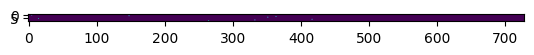

In [61]:
plt.imshow(xenc.view(-1,729)[:10,0:729])

In [108]:
W = torch.randn((27*27,27), generator=g, requires_grad=True)

In [109]:
for _ in range(2):
    logits = xenc.view(-1,729) @ W #log-counts
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xs.shape[0]),ys].log().mean()
    print(loss.item())
    probs.shape
    W.grad =  None
    loss.backward()
    W.data += -10 * W.grad + 0.01 * (W ** 2).mean()

3.923356533050537
1.9896160364151


In [110]:
# gen = torch.Generator().manual_seed(2147483648)
for _ in range(10):
    out = ['.','.']
    idx1 = 0
    
    while True:
        x_enc_1 = torch.nn.functional.one_hot(torch.tensor([idx1]), num_classes=27*27).float()
        # x_enc_2 = torch.nn.functional.one_hot(torch.tensor([idx2]), num_classes=27).float()
        
        logits = torch.matmul(x_enc_1, W)
        counts = logits.exp()
        probs = torch.div(counts, torch.sum(counts, dim=1, keepdims=True))
        # print(probs.shape)
        idx = torch.multinomial(probs, num_samples=1,  generator=g).item()
        if idx == 0:
            break
        out.append(itos[idx])
        # print(out)
        idx1 = (idx1%27)*27 + idx
        
    print("".join(out))

..yubmeupueonwxzilnuqxzdblocumyebgqmebudbtlobkhaonx
..emmabrdbbzbtnctljibkxmtzcnfagamnyfnztohobolbdoiuqcobofgazo
..emmahicsfctmdosquljdwwe
..eb
..ehvethprmma
..ilccyyzvfxskoazezhklzcrrqgevwzeycykcakrssgcxfntdunwhdxaydleuxvdmzdlrlg
..emjasjqifyenirqrovfsalejwoyilbhhslrcxyeycmjnfvupqvdcz
..eesuxejvcxzskrykzujyazvyvimlayvsgn
..enujpnlqzqkjdjgqvzsevyvmkiqslygrtrzy
..emmtusrlvrrkabawcfppnltzsykxdhyvsjowoswyctauvchqflhgzpfotronvoacnx


In [69]:
len(ys)

228146

In [53]:
xs[:10]

[[0], [5], [148], [364], [352], [0], [15], [417], [333], [265]]

In [33]:
#quickly check for counts for a specific input, output combo
def look_up_counts(combo):
    ch1, ch2, ch3 = combo
    return M[stoi[ch1]*27 + stoi[ch2], stoi[ch3]].item()

In [34]:
look_up_counts('..a')

4410

In [18]:
torch.nonzero(torch.all(SUMS==0, dim=1)).map

tensor([[ 27],
        [ 54],
        [ 60],
        [ 61],
        [ 65],
        [ 67],
        [ 70],
        [ 71],
        [ 76],
        [ 77],
        [ 78],
        [ 80],
        [ 81],
        [ 83],
        [ 87],
        [ 94],
        [ 95],
        [103],
        [104],
        [108],
        [124],
        [132],
        [135],
        [162],
        [164],
        [165],
        [166],
        [172],
        [175],
        [178],
        [179],
        [184],
        [186],
        [189],
        [192],
        [200],
        [205],
        [206],
        [213],
        [216],
        [240],
        [243],
        [270],
        [276],
        [277],
        [287],
        [294],
        [296],
        [297],
        [304],
        [313],
        [314],
        [321],
        [324],
        [348],
        [351],
        [358],
        [368],
        [375],
        [378],
        [405],
        [432],
        [436],
        [439],
        [449],
        [454],
        [4

In [23]:
torch.any(SUMS>0, dim=1).sum().item()

602

In [11]:
SUMS[0:3]

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [   0,  207,  190,   31,  366,   55,   21,   17,   91,  154,   27,   75,
          632,  384,  623,   10,   17,    9,  482,  194,   72,  152,  243,    6,
           27,  173,  152],
        [   0,  169,    0,    0,    0,  253,    0,    0,    9,   41,    1,    0,
           85,    0,    0,   77,    0,    0,  646,    0,    0,   21,    0,    0,
            0,    4,    0]], dtype=torch.int32)

In [15]:
import torch

# create a 3x4 tensor with some rows containing all 0's
t = torch.tensor([[1, 2, 3, 4], [0, 0, 0, 0], [5, 6, 7, 0], [0, 0, 0, 0]])

# count the number of rows with all 0's
num_zero_rows = torch.all(t == 0, dim=0).sum().item()

print(num_zero_rows)  # Output: 2


0


In [17]:
torch.nonzero(torch.all(t == 0, dim=1))

tensor([[1],
        [3]])

In [19]:
import torch

# Create a tensor with random values
x = torch.rand(5, 4)

# Set some rows to all zeros
x[1, :] = 0
x[3, :] = 0

# Find the rows with all zeros
all_zero_rows = torch.all(x == 0, dim=1)
zero_row_indices = torch.nonzero(all_zero_rows)

# Select the rows with all zeros
zero_rows = torch.index_select(x, 0, zero_row_indices[:, 0])

# Map the rows to corresponding character representation modulo 3
char_repr = zero_rows % 3

print("Character representation modulo 3:", char_repr)


Character representation modulo 3: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
